##  EX_10  인공지능으로 세상에 없던 새로운 패션 만들기 

### 목표: CIFAR-10 이미지 생성하기🐥

#### lubric

1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다: 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.
2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다: gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.
3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다: 제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다..

#### 🚩keyword

 1) GAN: Generativ Adversial Nets: 생성적 적대 신경망 
 비지도 학습에 사용되는 인공지능 알고리즘으로, 제로섬 게임 틀 안에서 서로 경쟁하는 두 개의 신경 네트워크 시스템에 의해 구현된다. 이 개념은 2014년에 이안 굿펠로우(Ian. j. Goodfellow)에 의해 발표되었다.

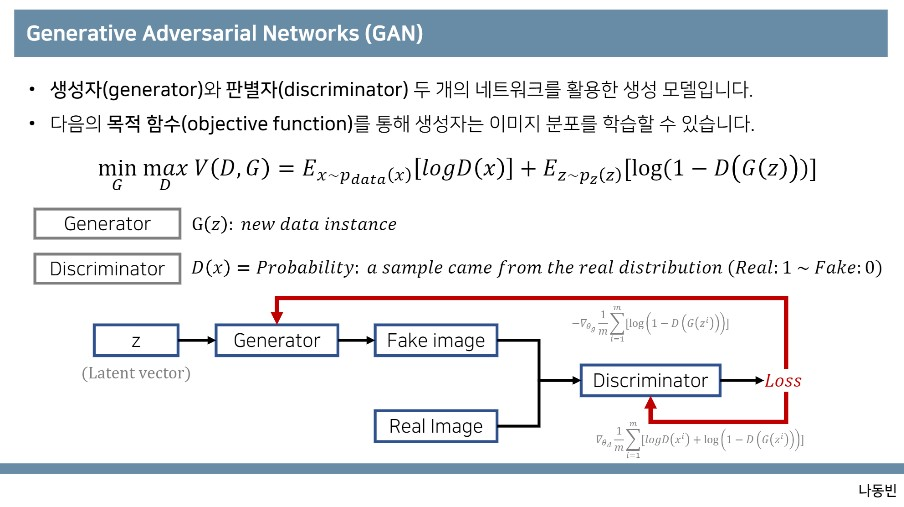

In [6]:
from IPython.display import Image

Image("img/gan3.jpg")

- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
- 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
- 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

#### STEP 2. 데이터 전처리

- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [58]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [59]:
# dataset load

cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()

# shape (32, 32, 3) 확인

train_x.shape

(50000, 32, 32, 3)

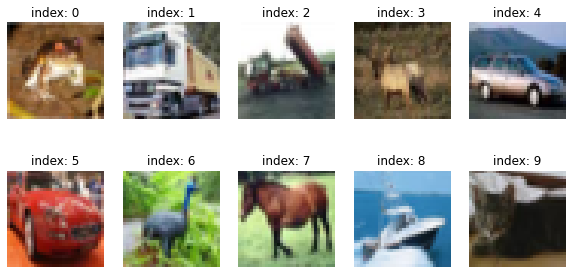

In [60]:
plt.figure(figsize=(10, 5)) # 프레임 크기 결정

for i in range(10):
    plt.subplot(2, 5, i+1) # 여러 이미지 띄우기
    plt.imshow(train_x[i], cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [61]:
# 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠줍니다.

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [62]:
# 미니배치 데이터셋 구성

BUFFER_SIZE = 60000 # 데이터셋 크기인 5000보다 더 크게 60000 설정
BATCH_SIZE = 256

In [63]:
# 버퍼사이즈 만큼 랜덤으로 섞고 배치사이즈에 맞게 자르기

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [64]:
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

#### STEP 3. generator 모델 구현

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해보기.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

In [87]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [88]:
generator = make_generator_model()

generator.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_30 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_30 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_31 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 8, 8, 128)       

In [89]:
noise = tf.random.normal([1, 100])

In [90]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

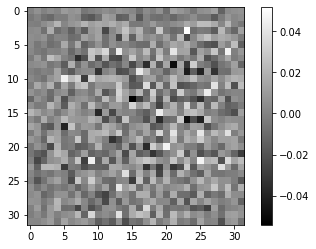

In [91]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

#### STEP 4. discriminator 모델 구현

- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [92]:
def make_discriminator_model(input_shape=(32, 32, 3)):

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [93]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)            

In [94]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00066127]], dtype=float32)>

#### STEP 5. 손실함수와 최적화 함수 구현하기

- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다

- GAN은 손실함수로 Crossentropy를 사용
: Cross Entropy는 두 값이 얼마나 멀어져있는 지를 정량적으로 계산할 때 쓰이는 함수.
특히 판별자는 한개의 이미지가 진짜인지 가짜인지 2개의 클래스 분류 문제를 풀어야하므로, 이진 교차 엔트로피(binary cross entropy)를 사용

- def generator_loss(fake_output) : C 생성한 이미지가 판별자를 얼마나 잘 속였는지 파악(fake_output이 1에 가까워지게)

- def discriminator_loss(real_output, fake_output) : 판별자가 진실과 거짓을 얼마나 잘 판별했는지 확인 (real_output은 1에 가까워지고, fake_output은 0에 가까워지게)

- def discriminator_accuracy(real_output, fake_output) : 생성자가 이미지를 잘 만들어내면 판별자는 이미지가 진실인지 거짓인지를 판단하기 어려워 확률에 의존하게 된다. 즉, accuracy는 0.5에 수렴할 수록 생성자가 제대로 학습한 것이다.

In [95]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [96]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [97]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [98]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [99]:
# 최적화 함수
# 생성자와 판별자는 따로 훈련되기 때문에, 판별자와 생성자의 옵티마이저는 다르다.

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [100]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

#### STEP 6. 훈련과정 상세 기능 구현하기

- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [101]:
# - train_step(images, gen, dis) : 미니배치 한 개 훈련 과정
# 생성자는 노이즈로부터 이미지를 생성해내어서 판별자에게 전달, 실제 원본 이미지도 판별자에게 전달한다.
# 두 출력 값을 통해 loss와 accuracy를 계산하고 gradient를 계산한다.

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [102]:
# generate_and_save_images(model, epoch, it, sample_seeds, dirno=1) : 훈련하면서 생성한 이미지를 시각화하는 함수.
# -1~1 사이로 정규화했던 데이터 셋을 다시 돌려놓는다.

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/EXPLORATIONS/EX_10/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

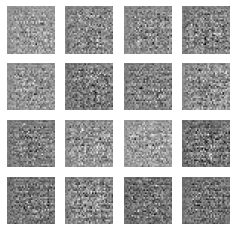

In [103]:
generate_and_save_images(generator, 30, 1, seed)

In [104]:
# draw_train_history(history, epoch, dirno) : GAN의 학습 과정을 기록하는 함수
# 매 step마다 train_step() 함수가 반환하는 gen_loss, disc_loss, real_accuracy, fake_accuracy를 딕셔너리 키로 삼고 매 학습에서 평가지표 각각의 값을 리스트로 저장한다.
# 한 epoch 마다 시각화

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/EXPLORATIONS/EX_10/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [105]:
# 체크포인트
# 앞서 정의한 optimizer 설정과 생성자, 판별자 모델을 입력으로 받아 tf.train.Checkpoint 객체를 생성

checkpoint_dir = os.getenv('HOME')+'/aiffel/EXPLORATIONS/EX_10/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#### STEP 7. 학습 과정 진행하기

- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

In [106]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [107]:
save_every = 5
EPOCHS = 10 # 기본 모델이니 10만 돌려봤다 원래는 200은 돌려야함

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

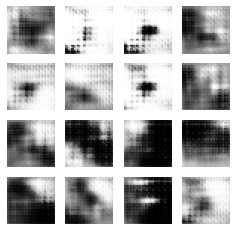

Time for training : 147 sec


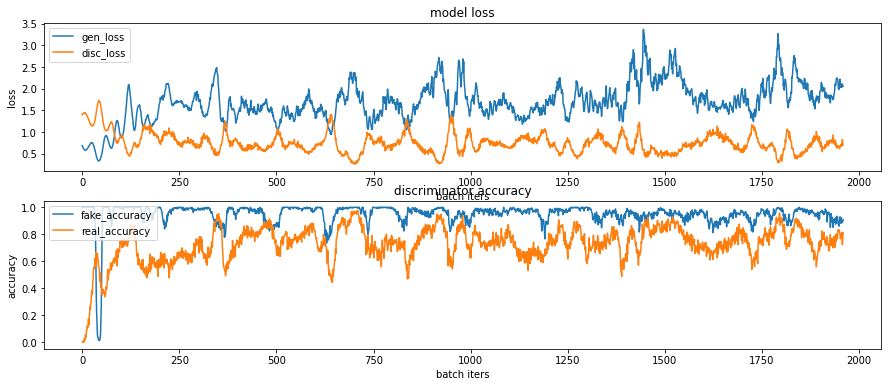

CPU times: user 2min 33s, sys: 15.3 s, total: 2min 48s
Wall time: 2min 27s


In [108]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

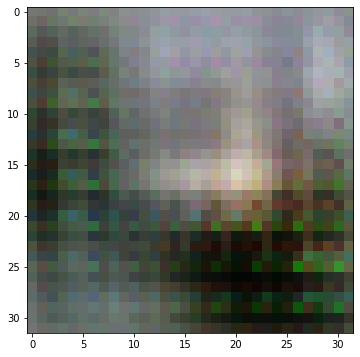

In [110]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

역시 그림이 제대로 나오지 않는다 

#### STEP 8. (optional) GAN 훈련 과정 개선하기

- STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
- 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

In [111]:
# 생성자 변형 시도

# Dense 입력 사이즈와 LeakyReLU alpha=0.2
# 커널 사이즈 5, 스트라이드 2

def make_generator_model(alpha=0.2):

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*64*8, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 512)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    # model.output_shape == (BACHE_SIZE, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha)) 

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [112]:
generator = make_generator_model()
generator.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 8192)              819200    
_________________________________________________________________
batch_normalization_33 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_33 (Conv2DT (None, 4, 4, 256)         3276800   
_________________________________________________________________
batch_normalization_34 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 4, 4, 256)       

In [113]:
# 판별자 변형시도

# layer 늘리고 LeakyReLU(alpha=0.2), Dropout(0.4)
# sigmoid는 실패

def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fifth: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1))

    return model

In [114]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 128)         147584    
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 2, 2, 128)       

In [115]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

In [116]:
save_every = 20
EPOCHS = 500

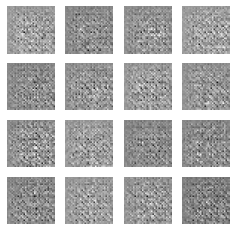

Time for training : 8396 sec


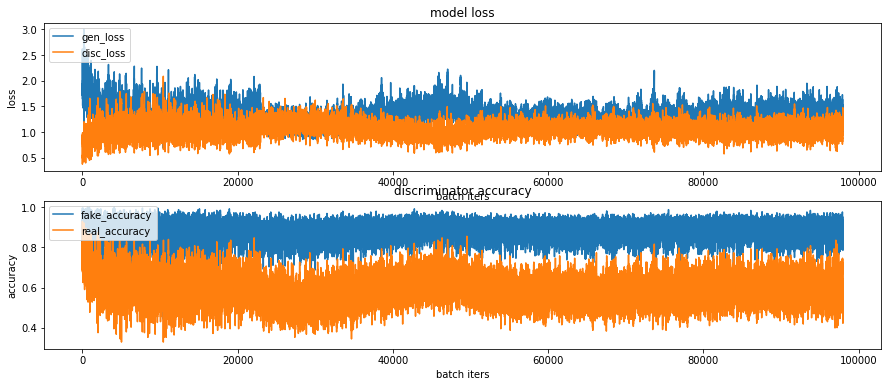

CPU times: user 2h 24min 14s, sys: 13min 27s, total: 2h 37min 42s
Wall time: 2h 20min 2s


In [117]:
%%time
train(train_dataset, EPOCHS, save_every)

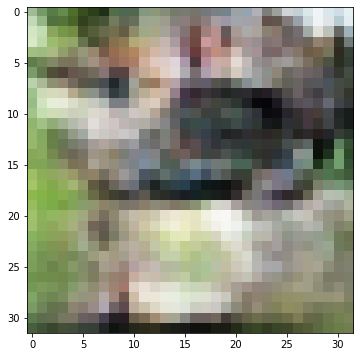

In [120]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

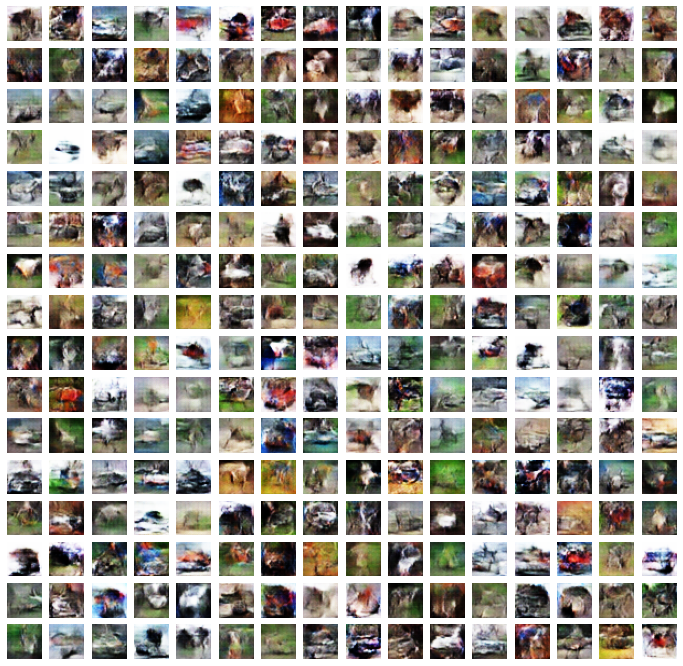

In [121]:
plt.figure(figsize=(12, 12))

for i in range(256):
    plt.subplot(16, 16, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.axis('off')
plt.show()

### trial and error

 - 일단 데이터로 할 수 있는 게 없어서 모델을 다시 쌓았는데 뭐가 꼬인건지 자꾸 error가 난다. 사실 기본 에폭을 200은 돌렸어야 했는데 조금 더 눈에 보이는 차이를 내기위해 기본 모델도 10만 돌렸다. 근데 계속 돌아가지 않아서 기분이 안 좋다~! 주변에서 오브젝트 종류를 육안으로 구별 가능한 거 맞냐고 했는데 이미지가 떴으니까 괜찮다. 그리고 gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다. 
 
- 마음을 가다듬고 모델을 다시 쌓아서 도전했다. 사실 모델링보다 데이터가 더 중요하다고 생각하는데 데이터로 해볼 수 있는 게 없어서 아쉬웠고 모델을 많이 쌓고 epoch도 500이나 돌렸는데 꽤나 만족스러운 결과가 나왔다. loss값이 괜찮았지만 acc값은 안 좋은 것 같은데 이만해도 첫 시도에 큰 성과라고 생각한다(너무 작은 거에 감사하나...)

- 여튼 이번 기회에 의도치 않게 발표도 GAN과 cycleGan을 맡아서 논문 분석부터 정말 열심히 공부했다. Gan에 대해 공부하며 사회, 윤리적 문제도 깊게 생각해 보며 이제는 제일 애착이 가는 모델이 된듯.